# Intro to Data Science
## Final project
## Porto Seguro’s Safe Driver Prediction

## Problem statement
### The existing algorithms of insurance claim prediction are not very accurate, what leads to more and more trustworthy drivers getting higher insurance bills than the ones who don't even know what being cautious on the road is. So the main problem we're trying to solve is that cautious drivers getting high insurance bills, because of poor accuracy of prediction algorithms that insurance companies use. That's why we need to improve the methods of insurance claim prediction, so that it will be possible for good drivers to be confident that they will have a discount.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load the data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

### There are the following columns in train dataset.

In [3]:
train.columns

Index(['id', 'target', 'ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03',
       'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin',
       'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin',
       'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15',
       'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01',
       'ps_reg_02', 'ps_reg_03', 'ps_car_01_cat', 'ps_car_02_cat',
       'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat',
       'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat',
       'ps_car_11_cat', 'ps_car_11', 'ps_car_12', 'ps_car_13', 'ps_car_14',
       'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04',
       'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09',
       'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14',
       'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin',
       'ps_calc_19_bin', 'ps_calc_20_bin'],


### Analyzing the dataset using seaborn, we found several interesting patterns. 

### Firstly, the following features: ps_calc_01, ps_calc_02, ps_calc_03 showed almost the same distribution for the 'target' values. But investigating this correspondence further, it was found there are probably no interconnections between the features. 

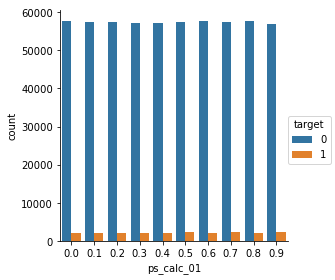

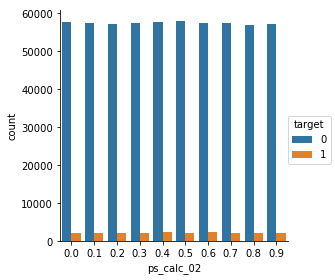

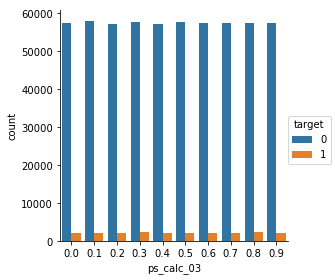

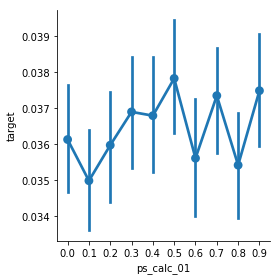

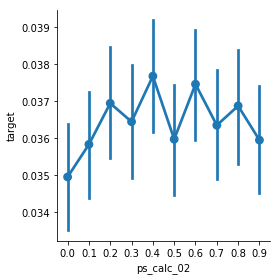

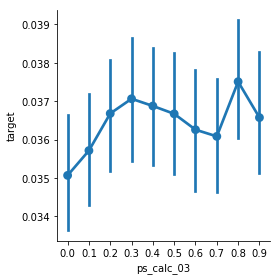

In [8]:
sns.factorplot(x="ps_calc_01", kind='count', hue='target', data = train)
sns.factorplot(x="ps_calc_02", kind='count', hue='target', data = train)
sns.factorplot(x="ps_calc_03", kind='count', hue='target', data = train)
sns.factorplot(x="ps_calc_01", y="target", data=train)
sns.factorplot(x="ps_calc_02", y="target", data=train)
sns.factorplot(x="ps_calc_03", y="target", data=train)

### And after building the pairplot graphs it became clear, that there are no obvious interconnections between these three features.

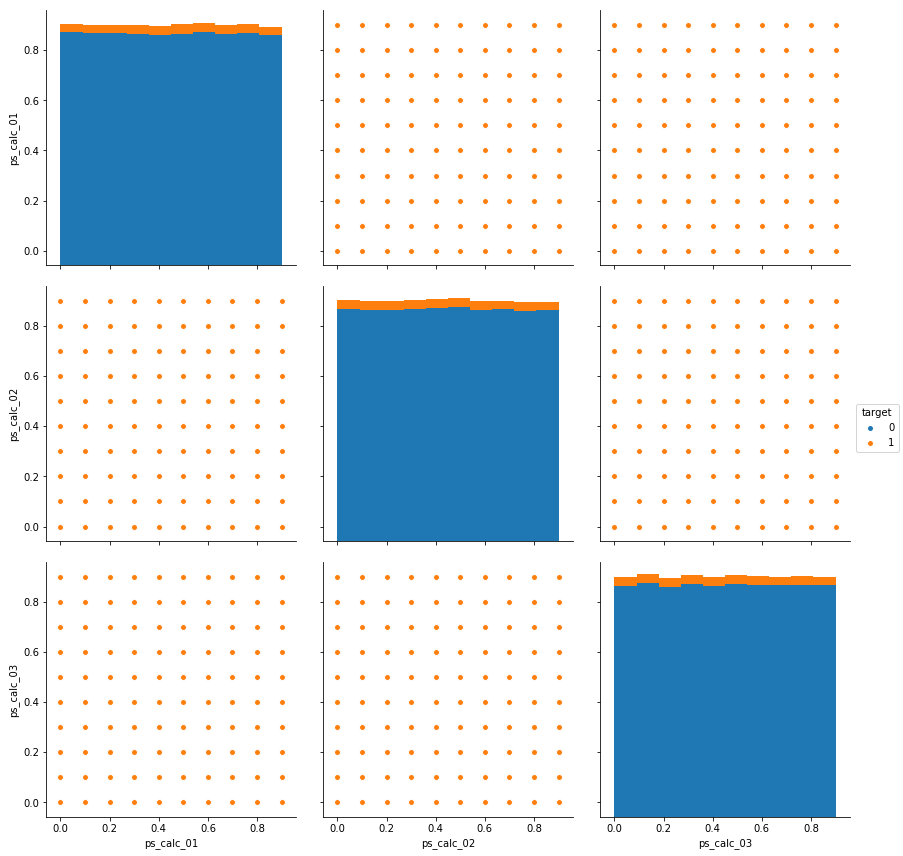

In [6]:
sns.pairplot(train, hue='target', vars=['ps_calc_01','ps_calc_02','ps_calc_03'], size=4)

### Secondly, there are some features in the data set, which could be removed, because they do not display any kind of influence on the target value.

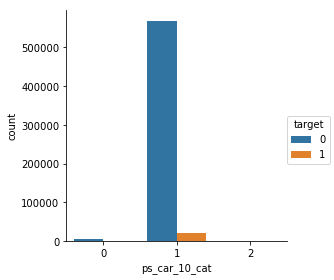

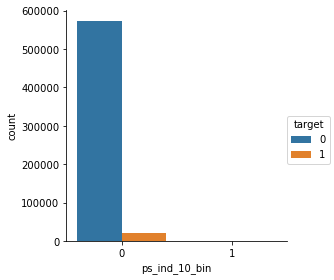

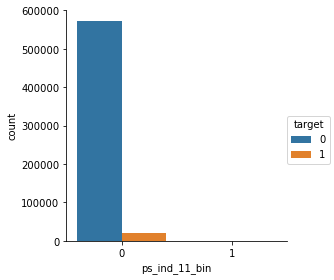

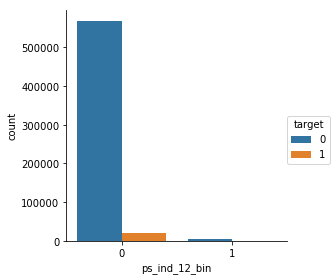

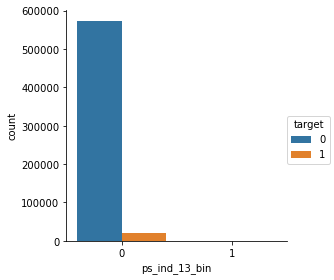

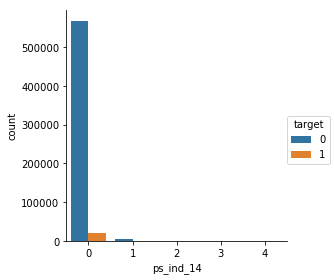

In [9]:
sns.factorplot(x='ps_car_10_cat', kind='count', hue='target', data = train)
sns.factorplot(x='ps_ind_10_bin', kind='count', hue='target', data = train)
sns.factorplot(x='ps_ind_11_bin', kind='count', hue='target', data = train)
sns.factorplot(x='ps_ind_12_bin', kind='count', hue='target', data = train)
sns.factorplot(x='ps_ind_13_bin', kind='count', hue='target', data = train)
sns.factorplot(x='ps_ind_14', kind='count', hue='target', data = train)

In [4]:
# split the data
X_train = train.drop(['id', 'target'], axis=1)
y_train = train['target']

X_test = test.drop(['id'], axis=1)

### We have checked in which columns there are missing values. The most part of the missing values is in categorical features. Only 4 numerical features have missing values. Missing values in numerical features will be tolerated by XGBoost algorithms. Missing values in cat features will be considered as the separate category while encoding procedure runs.

In [22]:
print([column_name for column_name in X_train.columns if -1 in X_train[column_name].values])

['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_reg_03', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_05_cat', 'ps_car_07_cat', 'ps_car_09_cat', 'ps_car_11', 'ps_car_12', 'ps_car_14']


In [23]:
print([column_name for column_name in X_test.columns if -1 in X_test[column_name].values])

['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_reg_03', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_05_cat', 'ps_car_07_cat', 'ps_car_09_cat', 'ps_car_11', 'ps_car_14']


### Some categorical features have high cardinality. So, the idea is to use target mean for cat features encoding.

In [24]:
def target_mean_encoding(train_feature, test_feature, target):
    temp = pd.concat([train_feature, target], axis=1)
    temp = temp.groupby(by=train_feature)[target.name].agg(['mean'])
    encoded_train_feature = pd.merge(train_feature.to_frame(), temp.reset_index(), how='left')
    encoded_train_feature = encoded_train_feature.drop(train_feature.name, axis=1)
    encoded_test_feature = pd.merge(test_feature.to_frame(), temp.reset_index(), how='left')
    encoded_test_feature = encoded_test_feature.drop(test_feature.name, axis=1)
    return (encoded_train_feature.rename(columns={'mean': train_feature.name})[train_feature.name],
            encoded_test_feature.rename(columns={'mean': test_feature.name})[test_feature.name])

In [25]:
cat_features = [feature for feature in X_train.columns if 'cat' in feature]

In [26]:
for feature in cat_features:
    X_train[feature], X_test[feature] = target_mean_encoding(X_train[feature], X_test[feature], y_train)

    
### The evaluation in this competition on Kaggle is performed by using normalized Gini coefficient. We have found that this metric can be calculated using ROC AUC, in particular, as 2 * roc_auc - 1. So, we will use the usual funaction and the roc_auc make evaluation in our CV procedure.

In [27]:
from sklearn.metrics import roc_auc_score

In [28]:
def gini(actual, pred):
    matrix = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)
    matrix = matrix[np.lexsort((matrix[:,2], -1*matrix[:,1]))]
    totalLosses = matrix[:,0].sum()
    giniSum = matrix[:,0].cumsum().sum() / totalLosses
 
    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)
 
def gini_normalized(a, p):
    return gini(a, p) / gini(a, a)

### We will use XGBoost for our classification task. To perform our CV procedure we use StratifiedKFold splitting from sklearn, because we have unbalanced targets in our dataset.

In [29]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold

### The internal cv feature of xgboost algorithms showed us that 100 estimators and learning rate 0.1 is OK for this task. So, we continue with tuning max_tree_depth parameter using grid search procedure. 

In [14]:
max_tree_depths = [3, 4, 6, 8]

for max_tree_depth in max_tree_depths:
    skf = StratifiedKFold()
    roc_auc_scores = []
    gini_scores = []

    for train_index, test_index in skf.split(X_train, y_train):
        X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]
        xgb = XGBClassifier(max_depth=max_tree_depth, missing=-1)
        xgb.fit(X_train_cv, y_train_cv)
        preds = xgb.predict_proba(X_test_cv)
        gini_scores.append(gini_normalized(y_test_cv, preds[:,1]))
        roc_auc_scores.append(2*roc_auc_score(y_test_cv, preds[:,1])-1)

    print('max_tree_depth value: ', max_tree_depth)
    print('gini (function): ', np.mean(gini_scores), '\tgini (roc auc): ', np.mean(roc_auc_scores))
    print()

max_tree_depth value:  3
gini (function):  0.275427958339 	gini (roc auc):  0.275427959786

max_tree_depth value:  4
gini (function):  0.27743021761 	gini (roc auc):  0.277430211582

max_tree_depth value:  6
gini (function):  0.274512398979 	gini (roc auc):  0.274512400426

max_tree_depth value:  8
gini (function):  0.260478704967 	gini (roc auc):  0.260478696286



### After choosing the optimal max_tree_depth value equals 4, we tune row_sabsampling and col_subsampling parameters also using grid search.

In [15]:
row_subsamplings = [0.5, 0.75, 1.0]
col_subsamplings = [0.4, 0.6, 0.8, 1.0]

for row_subsampling in row_subsamplings:
    for col_subsampling in col_subsamplings:
        skf = StratifiedKFold()
        roc_auc_scores = []
        gini_scores = []

        for train_index, test_index in skf.split(X_train, y_train):
            X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
            y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]
            xgb = XGBClassifier(max_depth=4, subsample=row_subsampling, colsample_bytree=col_subsampling, missing=-1)
            xgb.fit(X_train_cv, y_train_cv)
            preds = xgb.predict_proba(X_test_cv)
            gini_scores.append(gini_normalized(y_test_cv, preds[:,1]))
            roc_auc_scores.append(2*roc_auc_score(y_test_cv, preds[:,1])-1)

        print('row_subsampling value: ', row_subsampling, '\tcol_subsampling value: ', col_subsampling)
        print('gini (function): ', np.mean(gini_scores), '\tgini (roc auc): ', np.mean(roc_auc_scores))
        print()

row_subsampling value:  0.5 	col_subsampling value:  0.4
gini (function):  0.275016883648 	gini (roc auc):  0.275016883648

row_subsampling value:  0.5 	col_subsampling value:  0.6
gini (function):  0.276658761284 	gini (roc auc):  0.276658762971

row_subsampling value:  0.5 	col_subsampling value:  0.8
gini (function):  0.277567633542 	gini (roc auc):  0.277567627514

row_subsampling value:  0.5 	col_subsampling value:  1.0
gini (function):  0.277389970183 	gini (roc auc):  0.277389969219

row_subsampling value:  0.75 	col_subsampling value:  0.4
gini (function):  0.27660065253 	gini (roc auc):  0.276600659281

row_subsampling value:  0.75 	col_subsampling value:  0.6
gini (function):  0.277729157567 	gini (roc auc):  0.277729163113

row_subsampling value:  0.75 	col_subsampling value:  0.8
gini (function):  0.278897392593 	gini (roc auc):  0.278897387289

row_subsampling value:  0.75 	col_subsampling value:  1.0
gini (function):  0.279727759026 	gini (roc auc):  0.279727765054

row_s

### Now, we are ready to train our final model and make predictions for submitting on Kaggle.

In [16]:
xgb = XGBClassifier(max_depth=4, subsample=0.75, colsample_bytree=0.8, missing=-1)
xgb.fit(X_train, y_train)
preds = xgb.predict_proba(X_test)

In [162]:
result = pd.DataFrame(np.array([test['id'].values, preds[:,1]]).transpose(), columns=['id', 'target'])
result = result.astype({'id':int})
result.to_csv('result.csv', index=False)

## Conclusion
### The result is 0.276 score on Public LB.
### The maximum score on Public LB (as for 26 October 2017 at Kaggle) is 0,290 so the overall quality of model used in our project is descent. And it can definitely be used by insurance companies to improve their prediction algorithms.